## Repo Analysis

In [5]:
from utils.git_utils import clone_repo
from pathlib import Path
from analyzers.code_analyzer import CodeAnalyzer, NodeKind, is_kind, EdgeType
url = 'https://github.com/adiprerepa/cs598APE-hw1'
branch = 'pesquared-starting'

analyzer = CodeAnalyzer(url, branch)
PROJECT_DIR = analyzer.repo_path

✅ Uber file generated at /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/__uber.cpp
✅ Library subgraph loaded from /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/lib_subgraph.gpickle
Found 8127 nodes
Found 8453 edges
Adding edge from Ray::Ray to Vector::Vector
Adding edge from Ray::Ray to Vector::Vector
Adding edge from Camera::Camera to Vector::Vector
Adding edge from Camera::Camera to Vector::Vector
Adding edge from Camera::Camera to Vector::Vector
Adding edge from Camera::Camera to Vector::Vector
Adding edge from Light::Light to Vector::Vector
Adding edge from LightNode::LightNode to Light::Light
Adding edge from LightNode::LightNode to LightNode::LightNode
Adding edge from LightNode::LightNode to LightNode::LightNode
Adding edge from Shape::Shape to Vector::Vector
Adding edge from Shape::Shape to AABB::AABB
Adding edge from Shape::Shape to Texture::Texture
Adding edge from Shape::Shape to Texture::Texture
Adding edge from ShapeNode::ShapeNode to Shape::Shape
Adding edge from

⚠️ Graph is not a DAG. Using SCC condensation for level estimation.
⚠️ Found cycles: [['Autonoma::Autonoma', 'Shape::Shape'], ['Autonoma::Autonoma', 'ShapeNode::ShapeNode', 'Shape::Shape']]


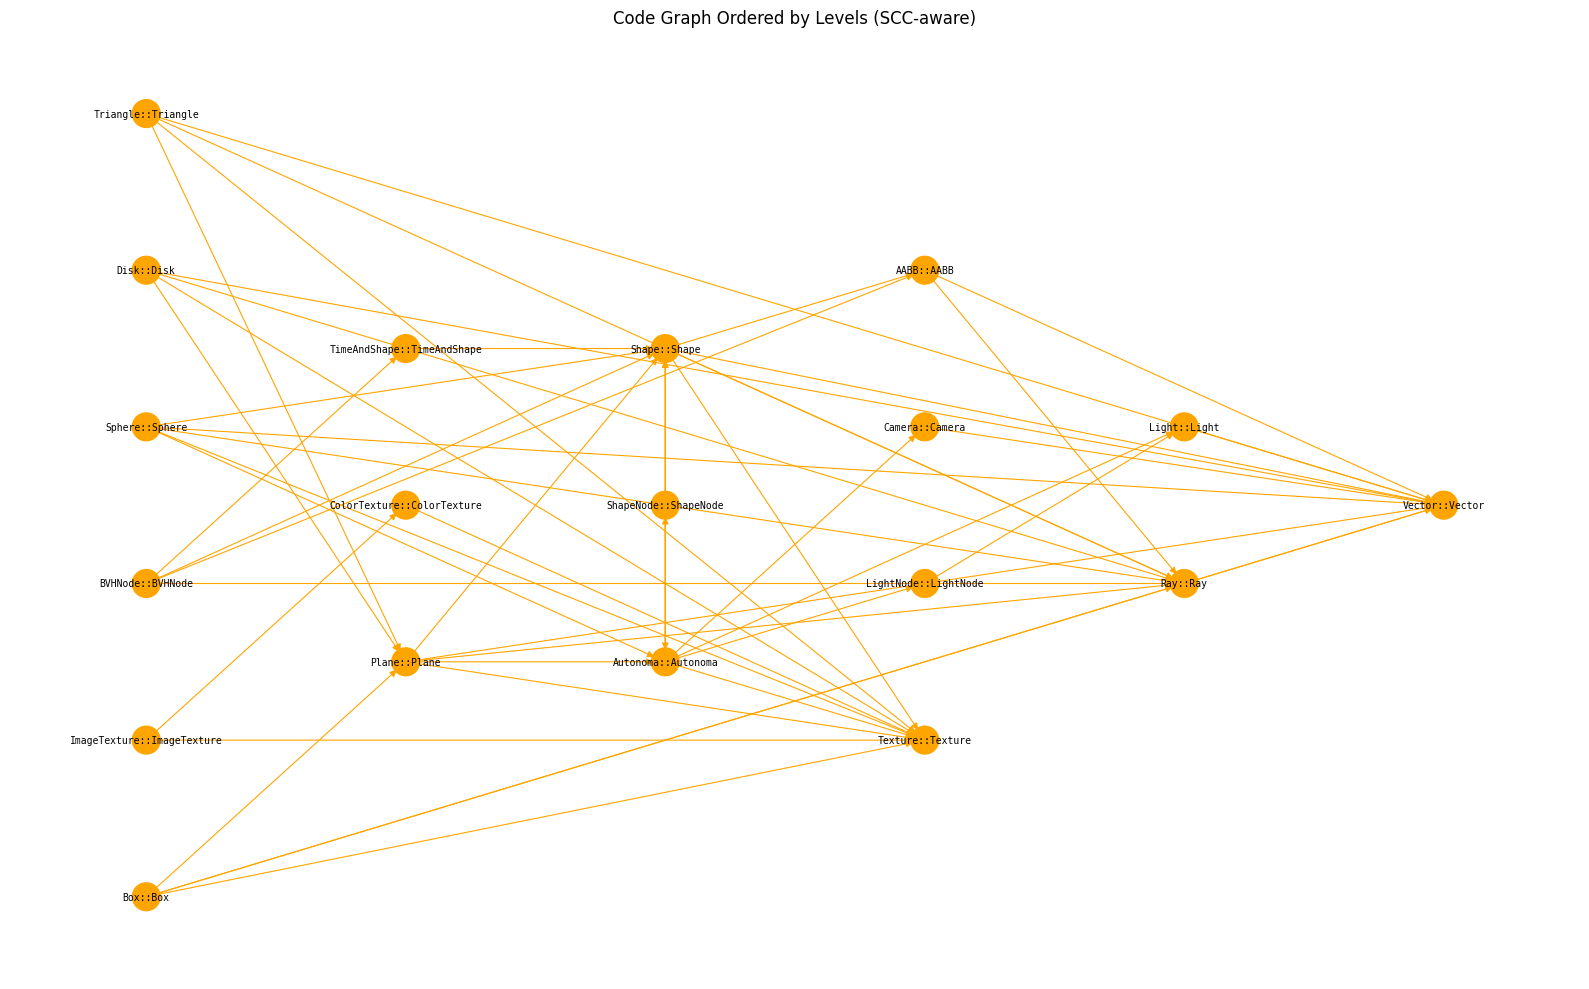

In [3]:
analyzer.plot(horizontal=True, node_filter=lambda node, attrs: (len(list(analyzer.predecessors(node))) != 0 or node == 'main(int, const char **)') 
              and is_kind(attrs["kind"], NodeKind.IN_CODEBASE) and is_kind(attrs['kind'], NodeKind.TYPE))
# neural training law

In [6]:
from collections import defaultdict

# Create a dictionary to store symbols and their corresponding signatures
symbol_to_signatures = defaultdict(list)

# Iterate through the nodes in the graph
for node, attrs in analyzer.nodes(data=True):
    if is_kind(attrs["kind"], NodeKind.FUNCTION):
        # remove the (...) signature from the function name
        symbol = node.split("(")[0]
        symbol_to_signatures[symbol].append(node)

# Convert defaultdict to a regular dictionary
symbol_to_signatures = dict(symbol_to_signatures)

# Print the resulting dictionary
is_bijectional = all(len(signatures) == 1 for signatures in symbol_to_signatures.values())
print("Is the mapping a bijection? ", is_bijectional)
non_bijectional = {symbol: signatures for symbol, signatures in symbol_to_signatures.items() if len(signatures) > 1}
# print the first 3 non-bijectional symbols
for symbol, signatures in list(non_bijectional.items())[:10]:
    print(f"Symbol: {symbol}, Signatures: {signatures}")

Is the mapping a bijection?  False
Symbol: Vector::operator*=, Signatures: ['Vector::operator*=(const double)', 'Vector::operator*=(const float)', 'Vector::operator*=(const int)']
Symbol: Vector::operator/=, Signatures: ['Vector::operator/=(const double)', 'Vector::operator/=(const float)', 'Vector::operator/=(const int)']
Symbol: Vector::operator*, Signatures: ['Vector::operator*(const double)', 'Vector::operator*(const float)', 'Vector::operator*(const int)']
Symbol: Vector::operator/, Signatures: ['Vector::operator/(const double)', 'Vector::operator/(const float)', 'Vector::operator/(const int)']
Symbol: operator*, Signatures: ['operator*(const int, const Vector &)', 'operator*(const double, const Vector &)', 'operator*(const float, const Vector &)']
Symbol: operator/, Signatures: ['operator/(const int, const Vector &)', 'operator/(const double, const Vector &)', 'operator/(const float, const Vector &)']
Symbol: Camera::Camera, Signatures: ['Camera::Camera(const Vector &)', 'Camera:

Function: Vector::dot, Signature: Vector::dot(const Vector &), Calls: 1629005763, Chain: ['main.exe', '_start', 'main', 'setFrame', 'refresh', 'calcColor', 'BVHNode::getMinTimeAndShape', 'Plane::getIntersection', 'Vector::dot']
Function: BVHNode::getMinTimeAndShape, Signature: BVHNode::getMinTimeAndShape(Ray), Calls: 1533427828, Chain: ['main.exe', '_start', 'main', 'setFrame', 'refresh', 'calcColor', 'BVHNode::getMinTimeAndShape']
Function: Vector::Vector, Signature: Vector::Vector(double, double, double), Calls: 1323788368, Chain: ['main.exe', '_start', 'main', 'setFrame', 'refresh', 'calcColor', 'getLight', 'Box::getLightIntersection', 'Vector::operator+', 'Vector::Vector']
Function: AABB::intersects, Signature: AABB::intersects(Ray), Calls: 1160679654, Chain: ['main.exe', '_start', 'main', 'setFrame', 'refresh', 'calcColor', 'BVHNode::getMinTimeAndShape', 'AABB::intersects']
Function: Box::getLightIntersection, Signature: Box::getLightIntersection(Ray, double *), Calls: 857722366, 

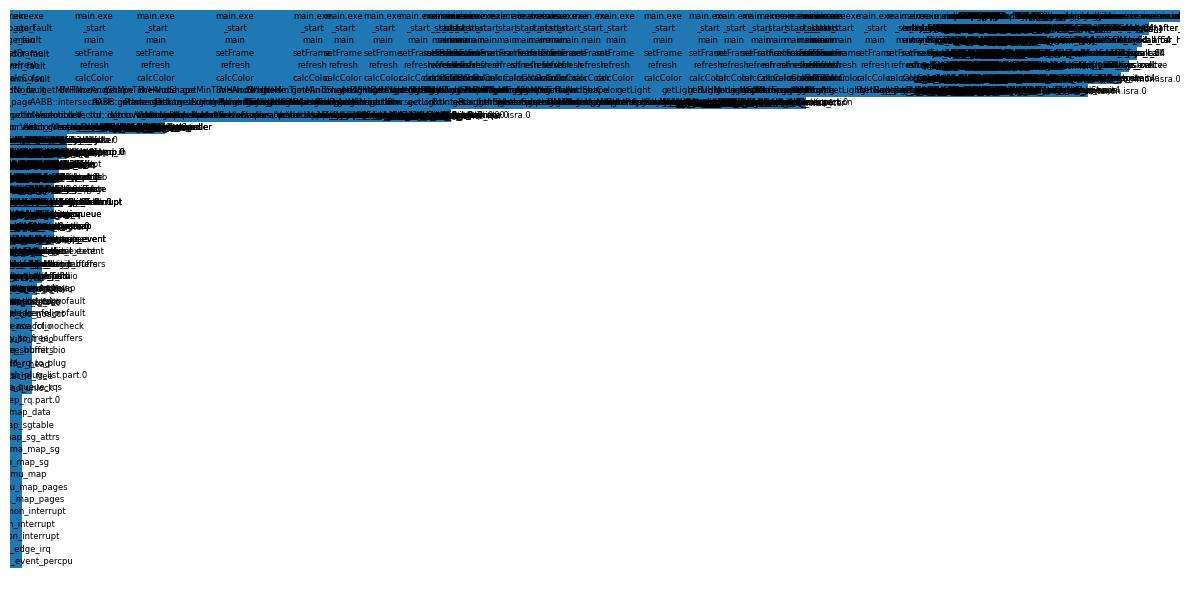

In [7]:
from analyzers.stack_analyzer import StackAnalyzer, FunctionStats

stack_analyzer = StackAnalyzer(f'{PROJECT_DIR}/perfstacks')
stats = stack_analyzer.get_top_functions(7)
for stat in stats:
    corresponding_signatures = symbol_to_signatures.get(stat.name, [])
    if len(corresponding_signatures) == 1:
        print(f"Function: {stat.name}, Signature: {corresponding_signatures[0]}, Calls: {stat.exclusive_time}, Chain: {stat.call_chain}")
    elif len(corresponding_signatures) > 1:
        print(f"Warning - multiple signatures found for function: {stat.name}")
        print(f"Function: {stat.name}, Signatures: {', '.join(corresponding_signatures)}, Calls: {stat.exclusive_time}")

stack_analyzer.plot()

In [7]:
from utils.cursor_utils import loc_info, CTOR_KINDS
from analyzers.code_analyzer import EdgeType
node = 'main(int, const char **)'
code = analyzer.nodes[node]['code']
print(f"Code for {node}:\n{code}")
# print the node's successors and the edge types
edges = list(analyzer.successors(node))
print(f"Successors of {node}:")
for edge in edges:
    edge_type = EdgeType(analyzer[node][edge]['type']).name
    print(f"  {edge} ({edge_type})")
# print the node's predecessors
predecessors = list(analyzer.predecessors(node))
print(f"Predecessors of {node}: {predecessors}")
# print the url of the file
file = analyzer.nodes[node]['file']
line = analyzer.nodes[node]['line']
print(f"File: {file}:{line}")
# print if the node is library or user defined
node_kind = analyzer.nodes[node]['kind']
# Access all the member variables of NodeKind
kinds = list(NodeKind)
for kind in kinds:
    if is_kind(node_kind, kind):
        print(f"{node} is of kind {NodeKind(kind).name}")
# print the node's AST
ast = analyzer.nodes[node]['ast']
print(f"AST for {node}:\n{ast}")
cursor = analyzer.nodes[node]['cursor']

Code for main(int, const char **):
int main(int argc, const char** argv){

   int frameLen = 1;
   const char* inFile = NULL;
   const char* animateFile = NULL;
   const char* outFile = NULL;
   bool toMovie = true;
   bool png = true;
   for (int i=1; i<argc; i++) {
      if (streq(argv[i], "-H")) {
         if (i + 1 >= argc) {
            printf("Error -H option must be followed by an integer height");
         }
         H = atoi(argv[i+1]);
         i++;
         continue;
      }
      if (streq(argv[i], "-W")) {
         if (i + 1 >= argc) {
            printf("Error -W option must be followed by an integer width");
         }
         W = atoi(argv[i+1]);
         i++;
         continue;
      }
      if (streq(argv[i], "-F")) {
         if (i + 1 >= argc) {
            printf("Error -F option must be followed by an integer number of frames");
         }
         frameLen = atoi(argv[i+1]);
         i++;
         continue;
      }
      if (streq(argv[i], "-o")) {
         if (

In [ ]:
import subprocess
import json
import networkx as nx
from concurrent.futures import ThreadPoolExecutor, as_completed

def run_cli_and_get_successors(codebase_dir, function_name):
    try:
        result = subprocess.run(
            ["python3", "analyzers/dependency_extractor.py", codebase_dir, function_name],
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True
        )
        output = result.stdout.strip()

        successors = set()
        inside_func = False

        for line in output.splitlines():
            stripped = line.strip()
            if stripped.startswith("Function:"):
                inside_func = True
            elif stripped.startswith("Dependencies:"):
                continue
            elif "Function calls:" in stripped:
                continue
            elif stripped.startswith("- Name:"):
                name = stripped.split(":", 1)[-1].strip()
                if name:
                    successors.add(name)

        return function_name, successors

    except Exception as e:
        print(f"⚠️ Error running CLI for {function_name}: {e}")
        return function_name, set()

def compare_graph_to_cli(graph: nx.DiGraph, codebase_dir: str, max_workers: int = 8):
    print("\n🔍 Verifying successors (parallel)...")
    non_superset = []

    subgraph = analyzer.induce_subgraph(
        node_filter=lambda node, attrs: attrs["kind"] & NodeKind.FUNCTION and attrs["kind"] & NodeKind.IN_CODEBASE
    )

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_func = {
            executor.submit(run_cli_and_get_successors, codebase_dir, func): func
            for func in subgraph.nodes
        }

        for future in as_completed(future_to_func):
            func = future_to_func[future]
            cli_successors = set()
            try:
                func_name, cli_successors = future.result()
            except Exception as e:
                print(f"⚠️ Failed to get result for {func}: {e}")
                continue
            cli_successors = cli_successors
            graph_successors = graph.successors(func)
            # constraint the successors to only those which are functions or types
            graph_successors = {n for n in graph_successors if graph.nodes[n].get("kind") in {"function", "type"}}
            # if graph succesors is not a superset of cli successors
            if not cli_successors.issubset(graph_successors):
                non_superset.append((func, graph_successors, cli_successors))
                print(f"\n❌ Mismatch for: {func}")
                print(f"  ➤ Graph: {sorted(graph_successors)}")
                print(f"  ➤ CLI  : {sorted(cli_successors)}")
            else:
                print(f"\n✅ Match for: {func}")

    if not non_superset:
        print("\n✅ The graph is a superset of the CLI")
    else:
        print(f"\n❌ Found {len(non_superset)} non superset nodes.")

    return non_superset


print(str(PROJECT_DIR))

mismatches = compare_graph_to_cli(analyzer, str(PROJECT_DIR), max_workers=128)

/home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1

🔍 Verifying successors (parallel)...

❌ Mismatch for: cosfn
  ➤ Graph: []
  ➤ CLI  : ['cos']

✅ Match for: identity

❌ Mismatch for: Plane::getColor
  ➤ Graph: []
  ➤ CLI  : ['Texture::getColor', 'Vector::Vector', 'Vector::operator-', 'fix', 'solveScalers']

❌ Mismatch for: Plane::setAngles
  ➤ Graph: []
  ➤ CLI  : ['Vector::Vector', 'Vector::dot', 'cos', 'sin']

❌ Mismatch for: outputPPM
  ➤ Graph: []
  ➤ CLI  : ['fclose', 'fopen', 'fprintf', 'fwrite', 'outputPPM']

❌ Mismatch for: get
  ➤ Graph: []
  ➤ CLI  : ['std::operator|=']

❌ Mismatch for: parseTexture
  ➤ Graph: []
  ➤ CLI  : ['ColorTexture::ColorTexture', 'ImageTexture::ImageTexture', 'ImageTexture::maskImageAlpha', 'ImageTexture::setColor', 'exit', 'getline', 'printf', 'sscanf', 'streq']

❌ Mismatch for: refresh
  ➤ Graph: []
  ➤ CLI  : ['Ray::Ray', 'Vector::Vector', 'Vector::operator+', 'calcColor', 'operator*']

✅ Match for: Shape::getNormal

❌ Mismatch for: fpeek
  ➤ Gra

## Obfuscation

In [6]:
import hashlib
import os
import re
from pathlib import Path
from typing import Dict, Set, List

from clang import cindex
from clang.cindex import CursorKind

from utils.string_utils import remove_comments, word_list


class Obfuscator:
    _word_pat_cache: Dict[frozenset, re.Pattern] = {}

    _CURSOR_KINDS_BY_TIER: Dict[int, Set[CursorKind]] = {
        2: {  # Variable names (user-defined)
            CursorKind.VAR_DECL,
            CursorKind.PARM_DECL,
            CursorKind.FIELD_DECL,
            CursorKind.ENUM_CONSTANT_DECL,
            CursorKind.MACRO_INSTANTIATION,
            CursorKind.MACRO_DEFINITION,
            CursorKind.MEMBER_REF_EXPR,
            CursorKind.DECL_REF_EXPR,
        },
        3: {  # Add user-defined functions & class names
            CursorKind.FUNCTION_DECL,
            CursorKind.CXX_METHOD,
            CursorKind.CONSTRUCTOR,
            CursorKind.DESTRUCTOR,
            CursorKind.FUNCTION_TEMPLATE,
            CursorKind.STRUCT_DECL,
            CursorKind.CLASS_DECL,
            CursorKind.CLASS_TEMPLATE,
            CursorKind.TYPEDEF_DECL,
            CursorKind.TYPE_ALIAS_DECL,
            CursorKind.TYPE_ALIAS_TEMPLATE_DECL,
            CursorKind.ENUM_DECL,
            CursorKind.TEMPLATE_TYPE_PARAMETER,
            CursorKind.TEMPLATE_NON_TYPE_PARAMETER,
            CursorKind.TEMPLATE_TEMPLATE_PARAMETER,
            CursorKind.NAMESPACE,
            CursorKind.TEMPLATE_REF,
            CursorKind.TYPE_REF,
            CursorKind.CXX_BASE_SPECIFIER,
        },
        4: set()  # Same as tier 3, but allows library symbols
    }

    def __init__(self, tier: int, nodes: List[dict], project_root: Path, prefix: str = "o_"):
        if not (0 <= tier <= 4):
            raise ValueError("tier must be between 0 and 4")
        self.tier = tier
        self.prefix = prefix
        self.project_root = project_root.resolve()

        self._kinds = self._resolve_kinds()
        self._tokens = self._collect_tokens(nodes)
        self._obf_map = self._create_obf_map(self._tokens)
        self._pattern = self._compiled_word_pattern(self._tokens)

    def obfuscate(self, code: str) -> str:
        if not self._obf_map:
            return code
        if self.strip_comments:
            code = remove_comments(code)

        def repl(match: re.Match[str]) -> str:
            return self._obf_map[match.group(0)]

        return self._pattern.sub(repl, code)

    def deobfuscate(self, code: str) -> str:
        if not self._obf_map:
            return code
        reverse_map = {v: k for k, v in self._obf_map.items()}
        pattern = self._compiled_word_pattern(set(reverse_map))

        def repl(match: re.Match[str]) -> str:
            return reverse_map[match.group(0)]

        return pattern.sub(repl, code)

    @property
    def obfuscation_map(self) -> Dict[str, str]:
        return self._obf_map

    @property
    def strip_comments(self) -> bool:
        return self.tier >= 1

    def _resolve_kinds(self) -> Set[cindex.CursorKind]:
        if self.tier < 2:
            return set()
        kinds = set()
        for t in range(2, self.tier + 1):
            kinds.update(self._CURSOR_KINDS_BY_TIER.get(t, set()))
        return kinds

    def _collect_tokens(self, nodes: List[dict]) -> Set[str]:
        tokens = set()

        def _should_obfuscate(cur: cindex.Cursor) -> bool:
            if cur is None or cur.kind == CursorKind.TRANSLATION_UNIT:
                return False
            if cur.kind not in self._kinds:
                return False
            if self.tier >= 4:
                return True
            return self._is_user_defined(cur)

        def _recurse(cur: cindex.Cursor):
            if _should_obfuscate(cur) and cur.spelling:
                if ' ' in cur.spelling:
                    tokens.add(cur.spelling.split()[-1])
                else:
                    tokens.add(cur.spelling)
            for child in cur.get_children():
                _recurse(child)

        for node in nodes:
            cursor = node.get("cursor")
            if cursor:
                _recurse(cursor)

        return tokens

    def _create_obf_map(self, tokens: Set[str]) -> Dict[str, str]:
        mapping = {}
        used_words = set()
        for token in tokens:
            word = random.choice(word_list)[:5]
            while word in used_words or word in tokens:
                word = random.choice(word_list)[:5]
            used_words.add(word)
            mapping[token] = f"{self.prefix}{word}"
        return mapping

    def _compiled_word_pattern(self, words: Set[str]) -> re.Pattern:
        key = frozenset(words)
        if key in self._word_pat_cache:
            return self._word_pat_cache[key]
        altern = "|".join(map(re.escape, sorted(words, key=len, reverse=True)))
        pat = re.compile(rf"(?<!\w)(?:{altern})(?!\w)")
        self._word_pat_cache[key] = pat
        return pat

    def _is_user_defined(self, cursor: cindex.Cursor) -> bool:
        definition = cursor.get_definition()
        loc_file = (
            definition.location.file.name
            if definition and definition.location.file
            else cursor.location.file.name
            if cursor.location.file
            else None
        )
        if loc_file is None:
            return self.tier >= 4

        file_path = Path(loc_file).resolve()
        try:
            in_project = file_path.is_relative_to(self.project_root)
        except AttributeError:
            in_project = str(file_path).startswith(str(self.project_root))

        is_writeable = os.access(file_path, os.W_OK)
        return in_project or is_writeable or self.tier >= 4


import random
import textwrap

function_nodes = [node for node, attrs in analyzer.nodes(data=True) if is_kind(attrs["kind"], NodeKind.FUNCTION) and is_kind(attrs["kind"], NodeKind.IN_CODEBASE)]
random_node = random.choice(list(function_nodes))
successors = list(analyzer.successors(random_node))
nodes = [analyzer.nodes[n] for n in successors]
nodes.append(analyzer.nodes[random_node])

obfuscator = Obfuscator(tier=3, nodes=nodes, project_root=PROJECT_DIR)

code = "\n".join(n["code"] for n in nodes)

obfuscated_code = obfuscator.obfuscate(code)
deobfuscated_code = obfuscator.deobfuscate(obfuscated_code)

print("\nOriginal code:")
print(textwrap.indent(code, "  "))

print("\nObfuscated code:")
print(textwrap.indent(obfuscated_code, "  "))

print("\nObfuscation map:")
for orig, obf in obfuscator.obfuscation_map.items():
    print(f"  {orig} -> {obf}")

if remove_comments(deobfuscated_code) == remove_comments(code):
    print("\n✅ Deobfuscation successful!")
else:
    print("\n❌ Deobfuscation failed.")
    # print the deobfuscated code
    print(textwrap.indent(deobfuscated_code, "  "))
    


Original code:
  class Box : public Plane{
  public:
    Box(const Vector &c, Texture* t, double ya, double pi, double ro, double tx, double ty);
    Box(const Vector &c, Texture* t, double ya, double pi, double ro, double tx);
    double getIntersection(Ray ray);
    bool getLightIntersection(Ray ray, double* fill);
  };
  class Vector {
  public:
    double x, y, z;
    Vector(double a, double b, double c);

    void operator += (const Vector&);
    void operator -= (const Vector&);
    void operator *= (const double);
    void operator *= (const float);
    void operator *= (const int);
    void operator /= (const double);
    void operator /= (const float);
    void operator /= (const int);

    Vector operator + (const Vector&) const;
    Vector operator - (const Vector&) const;
    Vector operator * (const double) const;
    Vector operator * (const float) const;
    Vector operator * (const int) const;
    Vector operator / (const double) const;
    Vector operator / (const flo

## Optimization 📄

In [ ]:
from typing import Optional, List, Dict
import os
import openai
import anthropic
import google.generativeai as genai
from collections import deque
from utils.string_utils import extract_markdown_blocks, markdown_to_dict
import networkx as nx

class Optimizer:
    def __init__(self, model: str, provider: str = "openai", api_key: Optional[str] = None):
        self.model = model
        self.provider = provider.lower()
        self.api_key = api_key

        # Initialize the appropriate client
        if self.provider == "openai":
            self.client = openai.OpenAI(api_key=api_key)

        elif self.provider == "anthropic":
            self.client = anthropic.Anthropic(api_key=api_key)

        elif self.provider == "gemini":
            # Set API key securely and directly
            if not api_key:
                raise ValueError("Missing API key for Gemini provider.")
            
            genai.configure(api_key=api_key)
            self.client = genai  # Keep the module reference for later GenerativeModel use


        else:
            raise ValueError(f"Unsupported provider: {provider!r}. "
                             "Use one of ['openai', 'anthropic', 'gemini'].")

    def prompt(self,
               input_prompt: str,
               context_window: Optional[List[str]] = None,
               system_message: Optional[str] = "You are an expert C++ performance optimization engineer.",
               temperature: float = 0.7,
               max_tokens: int = 4096) -> str:

        # Build messages in the right shape for each provider
        if self.provider in ("openai", "anthropic"):
            # OpenAI- & Anthropic-style role-based messages
            messages = []
            if system_message:
                messages.append({"role": "system", "content": system_message})
            if context_window:
                messages.extend({"role": "user", "content": m} for m in context_window)
            messages.append({"role": "user", "content": input_prompt})

            if self.provider == "openai":
                resp = self.client.chat.completions.create(
                    model=self.model,
                    messages=messages,
                    temperature=temperature,
                    max_tokens=max_tokens,
                )
                return resp.choices[0].message.content

            else:  # anthropic
                resp = self.client.messages.create(
                    model=self.model,
                    messages=messages,
                    temperature=temperature,
                    max_tokens=max_tokens,
                )
                return resp.content[0].text

        elif self.provider == "gemini":
            # Use the configured genai client to create a model instance
            model = self.client.GenerativeModel(self.model)

            # Flatten messages into a prompt string
            full_prompt = ""
            if system_message:
                full_prompt += f"{system_message}\n\n"
            if context_window:
                full_prompt += "\n".join(context_window) + "\n\n"
            full_prompt += input_prompt

            # Generate response
            resp = model.generate_content(
                full_prompt,
                generation_config=self.client.types.GenerationConfig(
                    temperature=temperature,
                    max_output_tokens=max_tokens,
                )
            )
            return resp.text
        else:
            # Should never happen because __init__ guards this
            raise RuntimeError(f"Invalid provider: {self.provider!r}")

    def optimize_node(
        self,
        node: str,
        obfuscation_tier: int = 0,
        system_message: Optional[str] = None,
        callee_depth: int = 0,
        node_filter: Optional[callable] = None,   # expects lambda (node_id, attrs) -> bool
        edge_filter: Optional[callable] = None,   # expects lambda ((u,v), attrs) -> bool
        caller_depth: int = 0,
    ) -> str:
        """
        Optimize a code node from a graph.  Gathers up to `context_depth` hops
        of neighbors (filtered by node_filter/edge_filter), obfuscates them,
        sends to the LLM, then deobfuscates the diff.
        """
        # 1) Grab the code for the target node
        labels = analyzer.nodes[node]
        code = labels.get("code", "").strip()
        if not code:
            raise ValueError(f"Node {node!r} has no code")

        # 2) BFS out to collect context nodes up to context_depth
        lengths = nx.single_source_shortest_path_length(analyzer, node, cutoff=callee_depth)
        # drop the root, then apply node_filter
        callee_nodes = [
            n for n in lengths
            if n != node
            and (node_filter is None or node_filter(n, analyzer.nodes[n]))
        ]

        # 3) (Optional) apply edge_filter: ensure at least one valid path exists
        if edge_filter is not None:
            def has_valid_path(target):
                for path in nx.all_simple_paths(analyzer, source=node, target=target, cutoff=callee_depth):
                    # check every edge in this path
                    if all(
                        edge_filter((u, v), analyzer.edges[u, v])
                        for u, v in zip(path, path[1:])
                    ):
                        return True
                return False
            callee_nodes = [n for n in callee_nodes if has_valid_path(n)]
        
        # 3.5) add caller nodes using BFS on the predecessors (ensuring nodes and edge filters are applied)
        # We can't use the same function as above, because we need to check the predecessors
        caller_nodes = []
        bfs = deque([(node, caller_depth)])
        visited = set()
        while bfs:
            current_node, depth = bfs.popleft()
            if depth == 0:
                continue
            for pred in analyzer.predecessors(current_node):
                if pred not in visited and (node_filter is None or node_filter(pred, analyzer.nodes[pred])):
                    visited.add(pred)
                    caller_nodes.append(pred)
                    bfs.append((pred, depth - 1))
        

        # 4) Prepare obfuscator over the target + contexts
        ob_nodes = [analyzer.nodes[n] for n in [node] + callee_nodes + caller_nodes]
        obfuscator = Obfuscator(
            tier=obfuscation_tier,
            nodes=ob_nodes,
            project_root=PROJECT_DIR
        )

        # 5) Obfuscate each code snippet and build context_window
        context_window = []

        # Makefile FLAGS add to context window
        makefile_flags = analyzer.nodes["FLAGS"]["code"].strip()
        if makefile_flags:
            context_window.append(
                f"📄 Makefile FLAGS\n```Makefile\n{makefile_flags}\n```"
            )

        # Callees
        for n in callee_nodes:
            attrs = analyzer.nodes[n]
            snippet = attrs.get("code", "").strip()
            if snippet:
                ob_snippet = obfuscator.obfuscate(snippet)
                context_window.append(
                    f"📄 Callee — {obfuscator.obfuscate(n)}\n```cpp\n{ob_snippet}\n```"
                )

        # Callers
        for n in caller_nodes:
            attrs = analyzer.nodes[n]
            snippet = attrs.get("code", "").strip()
            if snippet:
                ob_snippet = obfuscator.obfuscate(snippet)
                context_window.append(
                    f"📄 Caller — {obfuscator.obfuscate(n)}\n```cpp\n{ob_snippet}\n```"
                )

        ob_code = obfuscator.obfuscate(code)
        obfuscated_node = obfuscator.obfuscate(node)

        # Determine if function is "long"
        is_long_function = len(code.splitlines()) > 90

        # 6) Build the structured prompt (unified-diff focus)
        prompt = (
            f"You are an expert C++ performance engineer. Optimize the following C++ function `{obfuscated_node}` for performance.\n\n"
            f"{'You may modify the signature if needed, but you MUST update all its callers accordingly.' if caller_depth else 'It is CRITICAL that you DO NOT modify the function signature.'}\n\n"
            +
            (
                'You have access to:\n'
                '- Callee context\n'
                '- Caller context\n\n'
            )
            +
            "Please note:\n"
            f"- Callees and Callers are NOT exclusive to `{obfuscated_node}` and might be used by other functions\n"
            f"{'- The code is fully correct and compilable as is' if (obfuscation_tier == 0) else '- The code has been obfuscated but is still correct and compilable as is'}\n\n"
            f"{'⚙️ Return strictly as unified diffs.' if is_long_function else '✍️ Return the changed functions as a drop-in replacement. Do not return a diff; Do NOT skip lines; return the full rewritten function.'}\n\n"
            "```cpp\n"
            f"{ob_code}\n"
            "```\n\n"
            "Structure your response as follows:\n\n"
            "# Performance Insights\n"
            "<Outline your plan of what to change and why>\n\n"
            "(For each function you change, write)\n"
            +
            (
                # If long: unified diffs section
                "# <function_name>\n"
                "Brief Description of Change:\n<brief description of change>\n"
                "New Imports:\n```cpp\n<new imports> or '// NO CHANGES NEEDED' if n/a\n```"
                "New Functions/Structs/Classes/Variables:\n```cpp\n<new objects> or '// NO CHANGES NEEDED' if n/a\n```"
                "Rewritten Function:\n```diff\n<unified diff> or '// NO CHANGES NEEDED' if n/a\n```\n\n"
                if is_long_function else
                # Else: drop-in replacement section
                "# <function_name>\n"
                "Brief Description of Change:\n<brief description of change>\n"
                "New Imports:\n```cpp\n<new imports> or '// NO CHANGES NEEDED' if n/a\n```"
                "New Functions/Structs/Classes/Variables:\n```cpp\n<new objects> or '// NO CHANGES NEEDED' if n/a\n```"
                "Rewritten Function:\n```cpp\n<fully rewritten function> or '// NO CHANGES NEEDED' if n/a\n```\n\n"
            )
            +
            (
                '(Optional - only if we need new flags in the Makefile)\n'
                '# Makefile FLAGS\n'
                '```Makefile\nFLAGS := <new build flags>\n```\n'
            )
            +
            'Your response is machine-processed, so follow the structure EXACTLY and include every detail verbosely'
        )

        # 7) Send to the LLM
        raw_resp = self.prompt(
            input_prompt=prompt,
            context_window=context_window,
            system_message=system_message
        )

        # 8) De-obfuscate and return
        return obfuscator.deobfuscate(raw_resp)

from dotenv import load_dotenv
load_dotenv()  # Automatically loads variables from .env into os.environ

# Example usage with Google Gemini:
optimizer = Optimizer(
    model="gemini-1.5-flash",
    provider="gemini",
    api_key=os.getenv("GEMINI_API_KEY")
)
response = optimizer.optimize_node(
    node=random_node,
    callee_depth=1,
    caller_depth=1,
    obfuscation_tier=3,
    node_filter=lambda node, attrs: is_kind(attrs["kind"], NodeKind.IN_CODEBASE),
)
print(response)


# Performance Insights
The original `Box` constructor performs redundant calculations and uses many temporary variables.  We can optimize this by:

1. **Reducing Redundant Calculations:** The code calculates `halfRight` and `halfUp` then uses them repeatedly in subsequent calculations. We can restructure the calculations to avoid this repetition.

2. **Eliminating Temporary Variables:**  Many temporary `Vector` variables are created. We can reduce memory allocation and improve performance by performing the calculations directly within the `AABB` constructor.

3. **Utilizing Member Initialization List:** We can leverage the member initializer list to initialize `bounds` directly, further reducing temporary variable creation.

4. **Vectorization (Potential):** If `std::min` and `std::max` are computationally expensive and support SIMD vectorization, we can explore using SIMD intrinsics to process multiple elements of `Vector` simultaneously. This requires compiler support and analysis of

In [12]:
resp_dict = markdown_to_dict(response)
resp_dict.cutoff = 0.3
resp_dict

{'performance insights': "The original `Autonoma::addShape` function uses `malloc` for memory allocation, which is slower and less efficient than using `new` within a class method.  Furthermore, it manually manages a doubly linked list, which introduces overhead for insertions at the end.  For improved performance, we'll switch to a `std::vector` for shape storage. This offers amortized constant time for appending elements, avoiding the pointer manipulation and memory allocation overhead of the manual linked list.  Using `std::vector` also leverages memory management provided by the standard library, which is typically more optimized than manual allocation.",
 'changes': '',
 '`autonoma::addshape`': '```cpp\nvoid Autonoma::addShape(Shape* shape) {\n  shapes_.push_back(shape);\n}\n```',
 '`createinputs`': 'This function needs to be updated to accommodate the change in `addShape`.  The original used a manual linked list, so we remove that logic.  We also allocate the `Autonoma` object us

## $\text{Optimization}^2$

In [15]:
def parse_diff(diff_text):
    """Parse a unified diff string into a list of hunks."""
    hunks = []
    current_hunk = []
    for line in diff_text.splitlines():
        if line.startswith('@@'):
            if current_hunk:
                hunks.append(current_hunk)
            current_hunk = [line]
        else:
            current_hunk.append(line)
    if current_hunk:
        hunks.append(current_hunk)
    return hunks

def parse_hunk_simple(hunk_lines):
    """Parse a hunk into leading context, trailing context, remove count, and add lines."""
    leading_context = []
    trailing_context = []
    remove_count = 0
    add_lines = []
    in_change = False
    for line in hunk_lines:
        if line.startswith(' '):
            if not in_change:
                leading_context.append(line[1:])
            else:
                trailing_context.append(line[1:])
        elif line.startswith('-'):
            in_change = True
            remove_count += 1
        elif line.startswith('+'):
            in_change = True
            add_lines.append(line[1:])
    return leading_context, trailing_context, remove_count, add_lines

def apply_hunk_fuzzy_simple(hunk_lines, corpus):
    """Apply a single hunk to the corpus fuzzily using context matching."""
    leading_context, trailing_context, remove_count, add_lines = parse_hunk_simple(hunk_lines)
    C_lead = len(leading_context)
    C_trail = len(trailing_context)
    
    # Skip if no context is provided to anchor the changes
    if C_lead == 0 and C_trail == 0:
        return
    
    # Search for the best position to apply the hunk
    best_score = -1
    best_i = -1
    max_pos = len(corpus) - C_lead - remove_count - C_trail + 1
    for i in range(max_pos if max_pos > 0 else 0):
        # Calculate similarity score for leading context
        score_lead = sum(1 for a, b in zip(corpus[i:i + C_lead], leading_context) if a == b)
        # Calculate similarity score for trailing context
        score_trail = sum(1 for a, b in zip(
            corpus[i + C_lead + remove_count:i + C_lead + remove_count + C_trail],
            trailing_context
        ) if a == b)
        score = score_lead + score_trail
        if score > best_score:
            best_score = score
            best_i = i
    
    # Apply the changes if a suitable position is found
    if best_i != -1:
        start_remove = best_i + C_lead
        end_remove = start_remove + remove_count
        del corpus[start_remove:end_remove]
        corpus[start_remove:start_remove] = add_lines

def apply_diff_fuzzy(corpus, diff_text):
    """
    Apply a diff with potentially inaccurate hunks to a corpus fuzzily.
    
    Args:
        corpus (list of str): The original text as a list of lines.
        diff_text (str): The diff in unified diff format.
    
    Returns:
        list of str: The modified corpus after applying the diff.
    """
    hunks = parse_diff(diff_text)
    for hunk in hunks:
        apply_hunk_fuzzy_simple(hunk, corpus)
    return corpus

# Example usage:

    # Sample corpus
file = analyzer.nodes[random_node]['file']
with open(file, 'r') as f:
    corpus = f.readlines()
corpus = analyzer.nodes[random_node]['code'].splitlines()
# Sample diff with one hunk
diff_text = extract_markdown_blocks(resp_dict['function'])[0]
# Apply the diff
modified_corpus = apply_diff_fuzzy(corpus, diff_text)
print("\n".join(modified_corpus))

Vector Plane::solveScalers(Vector C) {
    double v1xv2y = v1x * v2y;
    double v1xv2z = v1x * v2z;
    double v1yv2x = v1y * v2x;
    double v1yv2z = v1y * v2z;
    double v1zv2x = v1z * v2x;
    double v1zv2y = v1z * v2y;
    double v2xv3y = v2x * v3y;
    double v2xv3z = v2x * v3z;
    double v2yv3x = v2y * v3x;
    double v2yv3z = v2y * v3z;
    double v2zv3x = v2z * v3x;
    double v2zv3y = v2z * v3y;
    double a = C.z * v2yv3x - C.y * v2zv3x - C.z * v2xv3y + C.x * v2zv3y + C.y * v2xv3z - C.x * v2yv3z;
    double b = -C.z * v1yv3x + C.y * v1zv3x + C.z * v1xv3y - C.x * v1zv3y - C.y * v1xv3z + C.x * v1yv3z;
    double c = C.z * v1yv2x - C.y * v1zv2x - C.z * v1xv2y + C.x * v1zv2y + C.y * v1xv2z - C.x * v1yv2z;
    double invDenom = 1.0 / denom;

    return Vector(a * invDenom, b * invDenom, c * invDenom);
             + C.y * v1xv2z - C.x * v1yv2z;

   return Vector(a / denom, b / denom, c / denom);
}
